# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [ ]:
!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

In [ ]:
import os
import numpy as np
import pandas as pd
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

  0%|          | 0/3000 [00:00<?, ?it/s]

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

### Будем сохранять метрики для сравнения параметров модели

In [ ]:
!gdown --id '1dxwtL3QloJKFRVF6fc33wezS_vFZxqnI'
!mv side_effect.txt data/

In [ ]:
# перезапускал ячейки с разными side_context и параметрами модели
side_effect_file = 'data/side_effect.txt'
side_effect_description = 'Optimal'

side_context_cur = 2

side_effect = {
    'loss': {},
    'accuracy': {},
    'training_time': {},
    'YES_NO WER': {},
    'Digits WER': {}
}

if os.path.exists(side_effect_file):
    df = pd.read_csv(side_effect_file)
    df['loss'] = df['loss'].apply(eval)
    display(df)


,side_context,loss,accuracy,training_time,YES_NO WER,Digits WER,description
0,0,"[2.2824326110083035, 2.1633390502667913, 2.127...",0.427033,110.268977,10.0,20.0,NaN
1,1,"[2.0960227393380393, 1.895102188167389, 1.8282...",0.509849,107.076988,10.0,15.0,NaN
2,2,"[1.9666119439610943, 1.7325869040200816, 1.655...",0.551034,108.868322,0.0,0.0,NaN
3,3,"[1.8612791697272923, 1.6094740200617355, 1.525...",0.591441,111.806713,0.0,0.0,NaN
4,4,"[1.803051202218997, 1.5365993443463322, 1.4464...",0.611908,106.194712,0.0,0.0,NaN
5,5,"[1.7600204497675522, 1.4689778692885664, 1.375...",0.633826,99.256996,0.0,5.0,NaN
6,6,"[1.7298814870235883, 1.4361002834160874, 1.340...",0.642502,93.067176,0.0,15.0,NaN
7,0,"[2.3064655498371835, 2.180966949175575, 2.1449...",0.420906,96.088026,20.0,25.0,Minus hidden layer
8,1,"[2.1493808991194463, 1.9390734541605052, 1.869...",0.498058,93.828906,10.0,5.0,Minus hidden layer
9,2,"[2.019265978470947, 1.7718995031409166, 1.6915...",0.545448,91.488810,0.0,5.0,Minus hidden layer


### <b>Задание №1 (решение) </b>
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего.

In [ ]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        file_ali = ali_dict[file_name]
        frames_total = min(len(file_feats), len(file_ali)) 
        for frame in range(frames_total):
            # конкатенация кадров слева и справа от текущего
            ftr_frame = np.array([])
            for i in range(-side_context, side_context + 1):
                cur_frame = max(min(frame + i, frames_total - 1), 0)
                ftr_frame = np.append(ftr_frame, file_feats[cur_frame])
            data_list.append(np.append(ftr_frame, phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = side_context_cur
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [ ]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [ ]:
class MyNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNet, self).__init__()
        # params:
        input_dim = input_dim       # размерность входных признаков
        n_nodes_hl1 = 256
        n_nodes_hl2 = 256
        n_nodes_hl3 = 256
        n_nodes_hl4 = 256
        output_dim = output_dim     # количество выходных классов (фонем)
        # FC layers:
        self.fc1 = nn.Linear(input_dim, n_nodes_hl1)
        self.fc2 = nn.Linear(n_nodes_hl1, n_nodes_hl2)
        self.fc3 = nn.Linear(n_nodes_hl2, n_nodes_hl3)
        self.fc4 = nn.Linear(n_nodes_hl3, n_nodes_hl4)
        self.fc5 = nn.Linear(n_nodes_hl4, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return (x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
net = MyNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG IS STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = net(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG IS STARTED...


epoch 0:   0%|          | 0/4481 [00:00<?, ?it/s]

loss is: 1.9628


epoch 1:   0%|          | 0/4481 [00:00<?, ?it/s]

loss is: 1.7307


epoch 2:   0%|          | 0/4481 [00:00<?, ?it/s]

loss is: 1.6545


epoch 3:   0%|          | 0/4481 [00:00<?, ?it/s]

loss is: 1.6058


epoch 4:   0%|          | 0/4481 [00:00<?, ?it/s]

loss is: 1.5698


epoch 5:   0%|          | 0/4481 [00:00<?, ?it/s]

loss is: 1.5412


epoch 6:   0%|          | 0/4481 [00:00<?, ?it/s]

loss is: 1.5171


epoch 7:   0%|          | 0/4481 [00:00<?, ?it/s]

loss is: 1.4964


epoch 8:   0%|          | 0/4481 [00:00<?, ?it/s]

loss is: 1.4782


epoch 9:   0%|          | 0/4481 [00:00<?, ?it/s]

loss is: 1.4617
Time is: 1 min 53 sec


In [ ]:
side_effect['loss'][side_context] = loss_list
side_effect['training_time'][side_context] = end - start

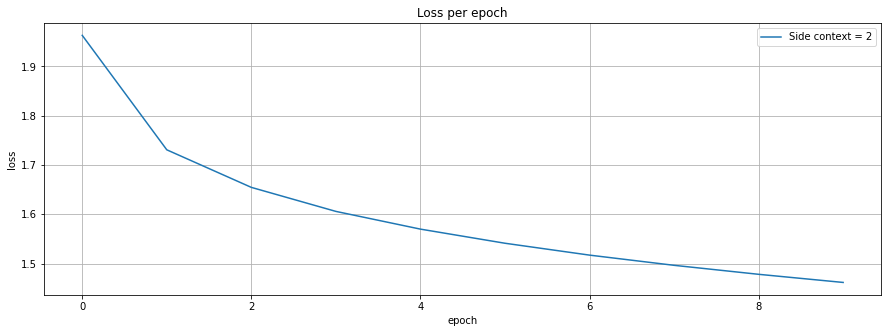

In [ ]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
for k, v in side_effect['loss'].items():
    plt.plot(v, label=f'Side context = {k}')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

In [ ]:
net.cpu()
with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        correct_cnt += (output.argmax().item() == true_label)
    
    frame_accuracy = correct_cnt / data_set.valid.shape[0]
    side_effect['accuracy'][side_context] = frame_accuracy
    print("Total frame accuracy is {:.3f}".format(frame_accuracy))

  0%|          | 0/127475 [00:00<?, ?it/s]

Total frame accuracy is 0.555


In [ ]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]
net.cpu()
with torch.no_grad():
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = net.forward(ftr)
        predict_label = output.argmax().item()
        
        class_correct[predict_label] += (predict_label == int(true_label))
        class_total[int(true_label)] += 1

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/127475 [00:00<?, ?it/s]

SIL: 0.96 : 21818/22687
SPN: 0.01 : 7/599
AA0: 0.00 : 0/28
AA1: 0.42 : 741/1767
AA2: 0.00 : 0/90
AE0: 0.00 : 0/49
AE1: 0.59 : 2171/3663
AE2: 0.00 : 0/90
AH0: 0.42 : 2364/5582
AH1: 0.26 : 501/1928
AH2: 0.00 : 0/38
AO0: 0.00 : 0/24
AO1: 0.48 : 920/1930
AO2: 0.00 : 0/52
AW0: 0.00 : 0/1
AW1: 0.31 : 337/1072
AW2: 0.02 : 1/42
AY0: 0.00 : 0/60
AY1: 0.63 : 1808/2867
AY2: 0.00 : 0/177
B  : 0.36 : 559/1573
CH : 0.41 : 380/936
D  : 0.34 : 1342/3948
DH : 0.45 : 891/1983
EH0: 0.00 : 0/68
EH1: 0.29 : 831/2846
EH2: 0.00 : 0/99
ER0: 0.41 : 1067/2628
ER1: 0.27 : 261/961
ER2: 0.00 : 0/15
EY0: 0.00 : 0/24
EY1: 0.58 : 1387/2394
EY2: 0.01 : 1/149
F  : 0.59 : 1369/2328
G  : 0.19 : 160/847
HH : 0.47 : 1026/2164
IH0: 0.15 : 388/2634
IH1: 0.15 : 333/2216
IH2: 0.00 : 0/69
IY0: 0.39 : 902/2299
IY1: 0.60 : 1442/2413
IY2: 0.02 : 1/56
JH : 0.23 : 137/600
K  : 0.55 : 1729/3132
L  : 0.68 : 2828/4153
M  : 0.54 : 1769/3260
N  : 0.59 : 3503/5948
NG : 0.33 : 432/1292
OW0: 0.01 : 3/211
OW1: 0.41 : 770/1864
OW2: 0.00 : 0/1

### Распознавание по словарю с помощью нейронки

In [ ]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [ ]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [ ]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold, side_context):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(len(features)):
        # конкатенация кадров слева и справа от текущего
        ftr_frame = np.array([])
        for i in range(-side_context, side_context + 1):
            cur_frame = max(min(frame + i, len(features) - 1), 0)
            ftr_frame = np.append(ftr_frame, features[cur_frame])        
        
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [ ]:
def run_recognizer(records_data_dict, graph, nnet, task, beam_threshold=10):
    start_time = time.time()
    recognition_results = []
    
    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results,
                                        beam_threshold,
                                        side_context)

    wer = (1 - sum(recognition_results)/len(recognition_results))*100
    side_effect[f'{task} WER'][side_context] = wer
    
    print("-" * 60)
    print(f"WER is: {wer:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [ ]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, net.cpu(), 'YES_NO', beam_threshold=100)

  0%|          | 0/10 [00:00<?, ?it/s]

result: no_4abb2400_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
result: yes_39a6b995_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_fe1916ba_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
------------------------------------------------------------
WER is: 0.00%
Total time is: 1.11 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [ ]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, net.cpu(), 'Digits', beam_threshold=50)

  0%|          | 0/20 [00:00<?, ?it/s]

result: nine_ccea893d_nohash_0      ==> NINE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: zero_f852895b_nohash_0      ==> ZERO
result: nine_fbe51750_nohash_0      ==> NINE
result: six_ffd2ba2f_nohash_0       ==> SIX
result: one_ffa76c4a_nohash_0       ==> FOUR
result: two_fce65496_nohash_0       ==> TWO
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: five_f852895b_nohash_0      ==> FIVE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: six_ffbb695d_nohash_0       ==> SIX
result: three_feb1d305_nohash_0     ==> THREE
result: two_fb2f3242_nohash_0       ==> TWO
result: eight_daf230ac_nohash_0     ==> EIGHT
result: eight_da584bc0_nohash_4     ==> FIVE
result: four_ffbb695d_nohash_0      ==> FOUR
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: one_fc2411fe_nohash_0       ==> ONE
result: three_fce96bac_nohash_0     ==> THREE
result: four_fce65496_nohash_0      ==> FOUR
------------------------------------------------------------
WER is: 10.00%
Total time is: 9.09 sec


### Сохраним результаты

In [ ]:
if os.path.exists(side_effect_file):
    df = pd.read_csv(side_effect_file)
    df['loss'] = df['loss'].apply(eval)
    
    dc = pd.DataFrame(side_effect).reset_index().rename(columns={'index': 'side_context'})
    dc['description'] = side_effect_description
    
    df = pd.concat([df, dc], axis=0)
    #df.to_csv(side_effect_file, index=False)
else:
    df = pd.DataFrame(side_effect).reset_index().rename(columns={'index': 'side_context'})
    df['description'] = side_effect_description
    #df.to_csv(side_effect_file, index=False)

df.tail(1)

,side_context,loss,accuracy,training_time,YES_NO WER,Digits WER,description
0,2,"[1.9627555461633261, 1.7306622306674326, 1.654...",0.555199,113.336157,0.0,10.0,Optimal


### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

In [ ]:
df[df.description.isna()]

,side_context,loss,accuracy,training_time,YES_NO WER,Digits WER,description
0,0,"[2.2824326110083035, 2.1633390502667913, 2.127...",0.427033,110.268977,10.0,20.0,NaN
1,1,"[2.0960227393380393, 1.895102188167389, 1.8282...",0.509849,107.076988,10.0,15.0,NaN
2,2,"[1.9666119439610943, 1.7325869040200816, 1.655...",0.551034,108.868322,0.0,0.0,NaN
3,3,"[1.8612791697272923, 1.6094740200617355, 1.525...",0.591441,111.806713,0.0,0.0,NaN
4,4,"[1.803051202218997, 1.5365993443463322, 1.4464...",0.611908,106.194712,0.0,0.0,NaN
5,5,"[1.7600204497675522, 1.4689778692885664, 1.375...",0.633826,99.256996,0.0,5.0,NaN
6,6,"[1.7298814870235883, 1.4361002834160874, 1.340...",0.642502,93.067176,0.0,15.0,NaN


Использование конкатенации кадров слева и справа от текущего дает хороший прирост в качестве распознавания (WER, accuracy). Значения side_context от 2 до 4 являются оптимальными. Большие значения приводял в переобучению подели, и как следствие, увеличаению ошибки распознавания на инференсе.

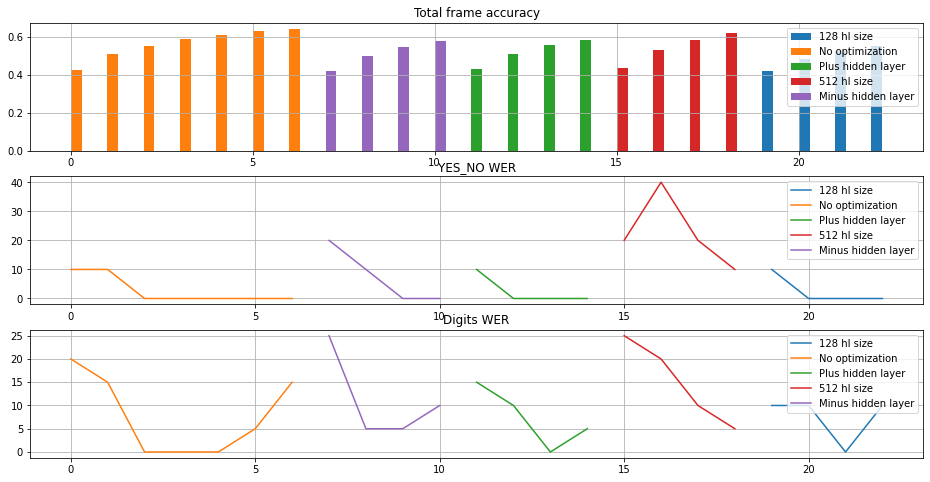

In [ ]:
df.description = df.description.fillna('No optimization')
labels = set(df.description.values)

plt.rcParams['figure.figsize'] = (16, 8)

plt.subplot(311)
for lbl in labels:
    data = df[df.description == lbl].accuracy
    plt.bar(data.index, data.values, width=0.3, label=lbl, align='edge')   
plt.title('Total frame accuracy')
plt.legend()
plt.grid()

plt.subplot(312)
for lbl in labels:
    data = df[df.description == lbl]['YES_NO WER']
    plt.plot(data, label=lbl)
plt.title('YES_NO WER')
plt.legend()
plt.grid()

plt.subplot(313)
for lbl in labels:
    data = df[df.description == lbl]['Digits WER']
    plt.plot(data, label=lbl)   
plt.title('Digits WER')
plt.legend()
plt.grid()

plt.show()

__Результаты (1 и 2 вопрос вместе)__:
- удаление одного скрытого слоя (Minus hidden layer) и добавление одного скрытого слоя (Plus hidden layer)  ожидаемо дают соттветственно снижение и и увеличение точности, в то же время при увеличении side_context модель медленней обучается и быстрее переобучается
- увеличение количества нейронов (512 hl size) во всех скрытых слоях быстро приводит в переобучению
- без существенной потери качества можно уменьшить количество нейронов в скрытых слоях до 128 (128 hl size)
- наиболее оптимальными являются исходные параметры модели (количество слоев 4, количество нейронов 256) с применением конкатенации 2 кадров слева и с права (side_context = 2)

Группа MADE-ML-22 Дмитрий Чepникoв

In [ ]:
df

,side_context,loss,accuracy,training_time,YES_NO WER,Digits WER,description
0,0,"[2.2824326110083035, 2.1633390502667913, 2.127...",0.427033,110.268977,10.0,20.0,No optimization
1,1,"[2.0960227393380393, 1.895102188167389, 1.8282...",0.509849,107.076988,10.0,15.0,No optimization
2,2,"[1.9666119439610943, 1.7325869040200816, 1.655...",0.551034,108.868322,0.0,0.0,No optimization
3,3,"[1.8612791697272923, 1.6094740200617355, 1.525...",0.591441,111.806713,0.0,0.0,No optimization
4,4,"[1.803051202218997, 1.5365993443463322, 1.4464...",0.611908,106.194712,0.0,0.0,No optimization
5,5,"[1.7600204497675522, 1.4689778692885664, 1.375...",0.633826,99.256996,0.0,5.0,No optimization
6,6,"[1.7298814870235883, 1.4361002834160874, 1.340...",0.642502,93.067176,0.0,15.0,No optimization
7,0,"[2.3064655498371835, 2.180966949175575, 2.1449...",0.420906,96.088026,20.0,25.0,Minus hidden layer
8,1,"[2.1493808991194463, 1.9390734541605052, 1.869...",0.498058,93.828906,10.0,5.0,Minus hidden layer
9,2,"[2.019265978470947, 1.7718995031409166, 1.6915...",0.545448,91.488810,0.0,5.0,Minus hidden layer
